# 1st Iteration of Masking
Here, the selected mask from the automatic segmentation are used as training and validation data for training TensorMask. The model is than thought to be used for infere more training data for the next training-inference iteration.

In [1]:
from google.colab import drive
import os
import sys

drive.mount("/content/drive")

# install dependencies:
!pip install pyyaml==5.1
!pip install torch==1.8.0 torchvision==0.9.0

import torch
import torchvision

print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2: (colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.8")
!pip install detectron2==0.4 -q -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# Colab's "restart runtime" is needed after installation
!pip install -q -U albumentations

os.chdir("drive/MyDrive/PG/pg_iss/")
assert os.getcwd().split("/")[-1] == "pg_iss"
# clone the repo at the same version, in order to access pre-defined configs
# !git clone --branch v0.4 https://github.com/facebookresearch/detectron2.git detectron2_repo
!pip install -q -e detectron2_repo/projects/TensorMask/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1.8.0 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
%load_ext autoreload
%autoreload 2

from detectron2.utils import comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.engine import (
    DefaultTrainer,
    DefaultPredictor,
    default_argument_parser,
    default_setup,
    launch,
)
from detectron2.evaluation import COCOEvaluator, verify_results
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
import random, cv2
import numpy as np
import albumentations as A
from google.colab.patches import cv2_imshow

sys.path.append("detectron2_repo/projects/TensorMask")

from lib import coco_handler, copy_and_paste_augm, constants
from lib.detectron2_utils import *
from lib.copy_and_paste_detectron import *

from tensormask import add_tensormask_config
import tensormask

import warnings

warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
os.environ["LRU_CACHE_CAPACITY"] = "1"

## Model setup

In [3]:
cfg = get_cfg()
add_tensormask_config(cfg)
cfg.merge_from_file("configs/fixed_image_config.yaml")
cfg.DATASETS.TRAIN = ("bug_train",)
cfg.DATASETS.TEST = ("bug_val",)
cfg.OUTPUT_DIR = "./output_bug_seg/aug/"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.TENSOR_MASK.NUM_CLASSES = 1
cfg.TEST.EVAL_PERIOD = 500
create_output(cfg)

## Augmentations

Here some standart image and mask augmentations are used to augment the input data. 

In [4]:
train_aug = A.Compose(
    [
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.augmentations.geometric.transforms.Affine(
            scale=(0.75, 1.25), rotate=(-45, 45), shear=(-5, 5), mode=1, p=0.75
        ),
        A.OneOf(
            [
                A.ElasticTransform(
                    alpha=1, sigma=2 * 0.05, alpha_affine=10 * 0.03, p=0.5
                ),
                A.GridDistortion(p=0.5, border_mode=cv2.BORDER_CONSTANT),
                A.OpticalDistortion(
                    distort_limit=0.1,
                    shift_limit=0.2,
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT,
                ),
            ],
            p=0.5,
        ),
        A.augmentations.geometric.resize.LongestMaxSize(800),
        A.OneOf(
            [
                A.augmentations.transforms.GaussNoise(var_limit=(10, 30)),
                A.augmentations.transforms.ImageCompression(
                    quality_lower=30, quality_upper=100
                ),
            ],
            p=0.5,
        ),
        A.CLAHE(p=0.8),
        A.RandomBrightnessContrast(p=0.8),
        A.RandomGamma(p=0.8),
    ],
)

test_aug = A.Compose([A.augmentations.geometric.resize.LongestMaxSize(800),])

## Setup the Datasets

In [5]:
img_dir = "data/mask_iter/1st_run/train/"
DatasetCatalog.register("bug_train", build_dataset_dict(img_dir))
register_coco_instances(
    "bug_val",
    {},
    "data/mask_iter/1st_run/bug_test.json",
    "data/mask_iter/1st_run/test/",
)
dataset_dicts = DatasetCatalog.get("bug_train")
MetadataCatalog.get("bug_train").set(thing_classes=["bug"])

Metadata(name='bug_train', thing_classes=['bug'])

## Train

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./output_bug_seg/

In [ ]:
class Trainer(BaseTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=build_mapper(train_aug))


trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
# trainer.train()

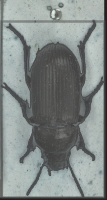

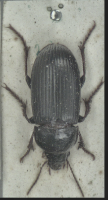

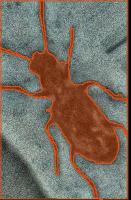

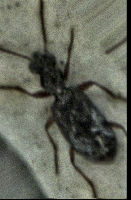

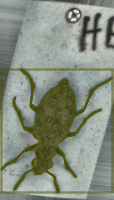

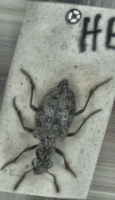

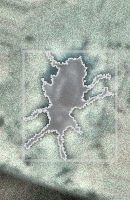

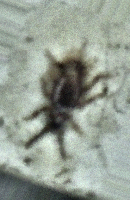

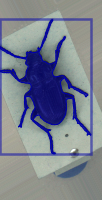

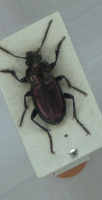

In [7]:
visualize_detectron2_loader(trainer.data_loader, cfg, scale=0.25)

## Inference
We infer the masks and compare them to the masks obtained via thresholding (*segment_bugs_from_crops*) in order to avoid needing to look at each mask manually. We assume that a high overlap of both masks means sucessful segmentation in both.

In [8]:
from lib.preprocessing import *
import pandas as pd
from tqdm import tqdm

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.TENSOR_MASK.SCORE_THRESH_TEST = 0.25
predictor = DefaultPredictor(cfg)

### Random examples

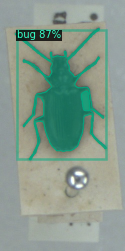

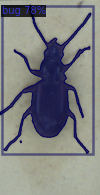

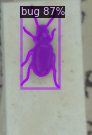

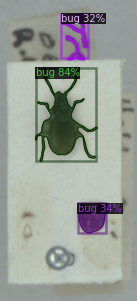

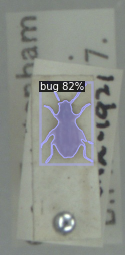

In [12]:
for path in np.random.permutation(
    glob(os.path.join(constants.path_to_data_dir, "raw/BugCrops", "*", "*"))
)[:5]:
    im = cv2.imread(path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("bug_val"), scale=0.5,)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

### Demonstrate IOU settings

This shows the image, the overlay of the prediction of the model (green) with the automatic segmentation (red), the raw IOU of both, and the modified IOU.

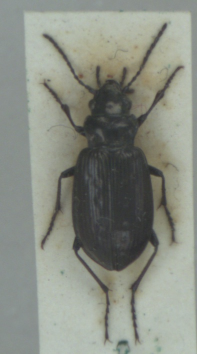

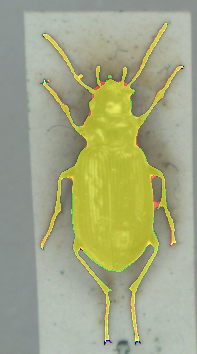

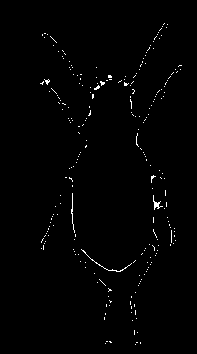

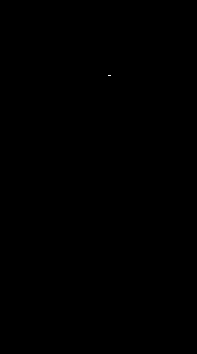

In [14]:
demonstrate_mod_IOU(
    os.path.join("data/raw/BugCrops", "4988516", "d039s0117.jpg"), predictor
)

We use modIOU rather than plain IOU as the pixels at the border of the bugs are neither informative nor relevant and the exact object outline is rather subjective. Hence the modified IOU version lays a greater focus on whole missing areas such as extremities like legs or antennae and is more meaningful.

### Run inference on whole set

Note, this may take while. Hence, intermediate results are saved as csv file and one might want to interrupt inference after some time as not all masks are need for evaluating the results.

In [ ]:
l = []
big_df = pd.DataFrame(l, columns=("species", "image", "IOU", "mod_IOU"))
for idx, path in enumerate(
    tqdm(
        np.random.permutation(
            glob(os.path.join(constants.path_to_data_dir, "raw/BugCrops", "*", "*"))
        )
    )
):
    if idx % 100 == 99:
        df = pd.DataFrame(l, columns=("species", "image", "IOU", "mod_IOU"))
        big_df = big_df.append(df)
        big_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "iou_res.csv"))
        l = []
    im = cv2.imread(path)
    outputs = predictor(im)
    if hasattr(outputs["instances"], "pred_masks"):
        pred = outputs["instances"].pred_masks.cpu().numpy()[0, :, :]
    else:
        continue
    try:
        mask = segment_bugs_from_crops(im)
    except:
        RuntimeError
        continue
    spec, img_name = path.split("/")[-2:]
    l.append([spec, img_name, i_o_u(pred, mask), mod_i_o_u(pred, mask)])

In [15]:
big_df = pd.read_csv("output_bug_seg/aug_1st_iter/iou_res.csv")

#### Results

Text(0.5, 1.0, 'Modified IOU')

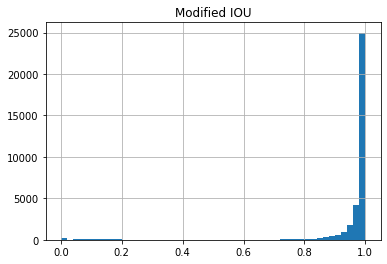

In [16]:
big_df["mod_IOU"].hist(bins=50)
plt.title("Modified IOU")

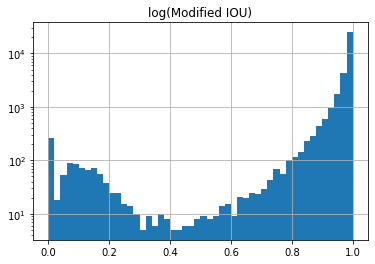

In [17]:
big_df["mod_IOU"].hist(bins=50)
plt.title("log(Modified IOU)")
plt.yscale("log")

In [18]:
print(sum(big_df["mod_IOU"] > 0.98) / len(big_df))

0.7115598211488623


In [19]:
print(sum(big_df["mod_IOU"] > 0.95) / len(big_df))

0.8606783812263264


Text(0.5, 0.98, 'IOU by species')

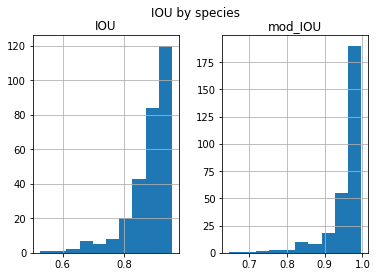

In [20]:
df = big_df.copy()
df.groupby("species").mean()[["IOU", "mod_IOU"]].hist()
plt.suptitle("IOU by species")

Hence, the majority of the predicted masks correspond well to the automatic thresholding masks and can be assumed to be nearly perfect. However, the accuracy is somewhat inconsistent between species. 

### Show examples from different modIOU ranges

(0.0, 0.9)


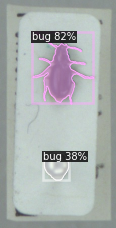

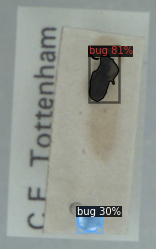

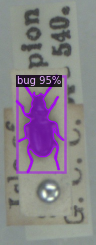

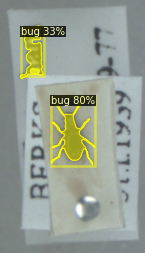

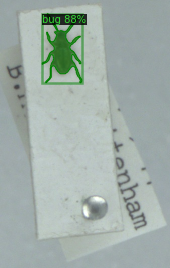

(0.9, 0.98)


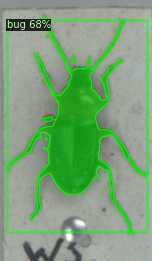

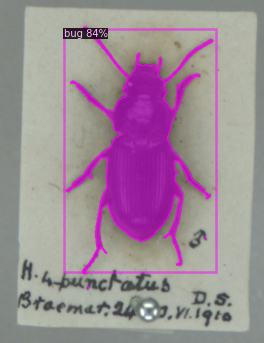

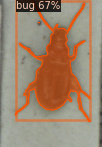

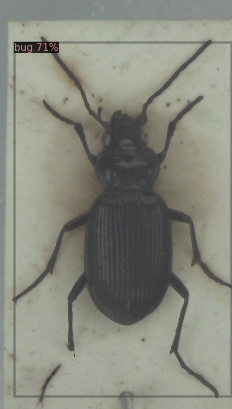

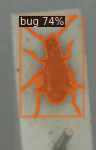

(0.98, 1)


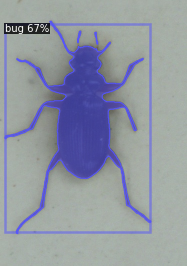

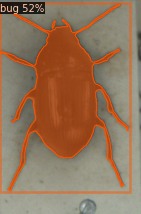

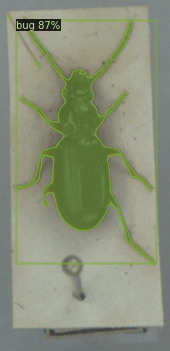

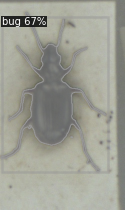

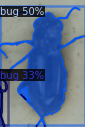

In [21]:
for t in [(0.0, 0.9), (0.90, 0.98), (0.98, 1)]:
    tmp = big_df.iloc[
        np.where(np.logical_and(big_df["mod_IOU"] >= t[0], big_df["mod_IOU"] < t[1]))
    ]
    print(t)
    for _ in range(5):
        s = tmp.sample()
        im = cv2.imread(
            f"data/raw/BugCrops/{s['species'].ravel()[0]}/{s['image'].ravel()[0]}"
        )
        if outputs:
            outputs = predictor(im)
            v = Visualizer(
                im[:, :, ::-1], metadata=MetadataCatalog.get("bug_val"), scale=0.5,
            )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            cv2_imshow(v.get_image()[:, :, ::-1])

We can observe that clearly writings and, to some extend, nails are a pitfall for mask predictions. 

### By Species

In [22]:
by_spec = df.groupby("species").mean().sort_values("mod_IOU")
by_spec

,Unnamed: 0,IOU,mod_IOU
species,,,
7683246,50.457143,0.525364,0.645969
4308811,52.407407,0.576741,0.714096
4308786,44.538462,0.620651,0.723620
4475677,49.854730,0.633683,0.749208
5872124,51.316872,0.677506,0.781485
...,...,...,...
4471235,42.421875,0.933542,0.996428
5755027,53.914894,0.933867,0.997061
9414758,48.757576,0.945165,0.997127


#### Visualize worst scoring species

7683246


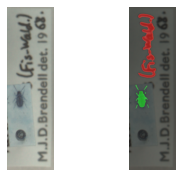

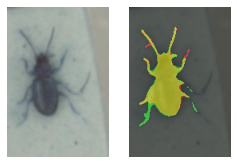

4308811


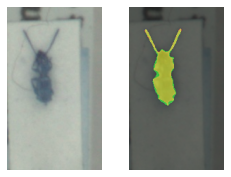

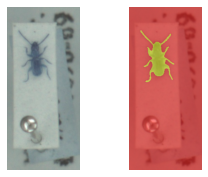

4308786


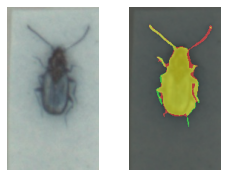

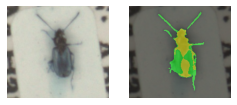

4475677


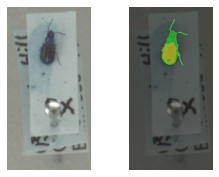

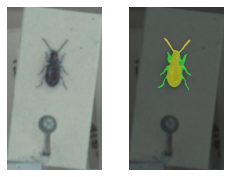

5872124


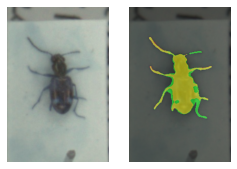

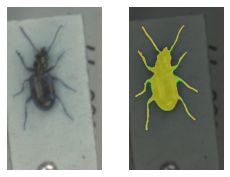

6097854


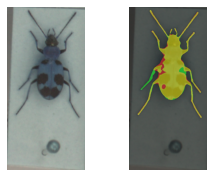

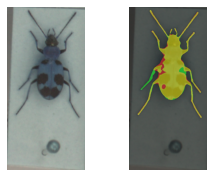

8607776


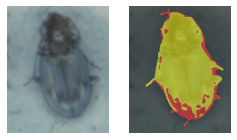

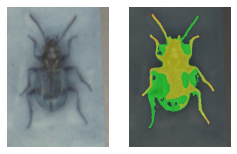

8139233


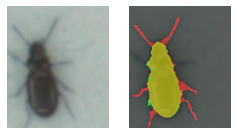

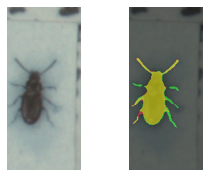

5872219


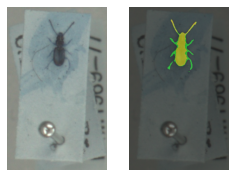

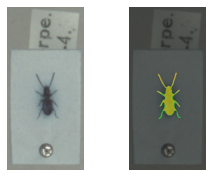

4480315


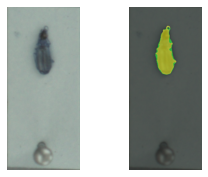

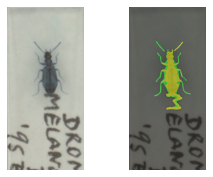

In [23]:
for spec in by_spec.iloc[:10].index.to_list():
    ch = np.random.choice(os.listdir(os.path.join("data/raw/BugCrops/", str(spec))), 2)
    print(spec)
    for sample in ch:
        try:
            plt.figure(figsize=(4, 3))
            im = cv2.imread(os.path.join(f"data/raw/BugCrops/{spec}/{sample}"))
            ax = plt.subplot(1, 2, 1)
            plt.imshow(im)
            ax.axis("off")

            outputs = predictor(im)
            pred = outputs["instances"].pred_masks.cpu().numpy()[0, :, :]
            mask = segment_bugs_from_crops(im)

            comp = im.copy() // 2
            comp[:, :, 1] += (pred * 128).astype(np.uint8)
            comp[:, :, 0] += (mask // 2).astype(np.uint8)

            ax = plt.subplot(1, 2, 2)
            plt.imshow(comp)
            ax.axis("off")
            plt.show()
        except RuntimeError:
            continue

#### Visualize best scoring species

4471235


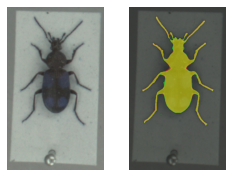

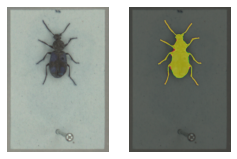

5755027


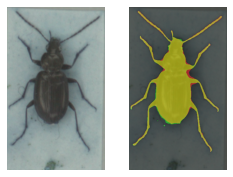

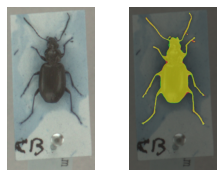

9414758


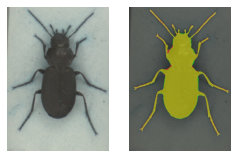

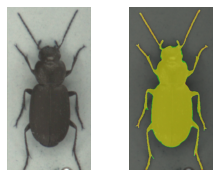

1035366


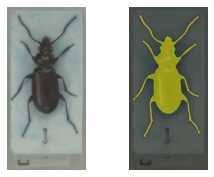

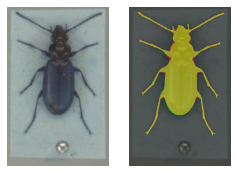

4471269


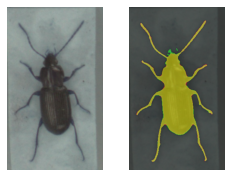

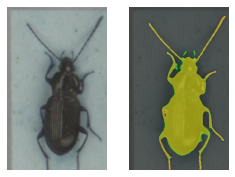

In [24]:
for spec in by_spec.iloc[-5:].index.to_list():
    ch = np.random.choice(os.listdir(os.path.join("data/raw/BugCrops/", str(spec))), 2)
    print(spec)
    for sample in ch:
        try:
            plt.figure(figsize=(4, 3))
            im = cv2.imread(os.path.join(f"data/raw/BugCrops/{spec}/{sample}"))
            ax = plt.subplot(1, 2, 1)
            plt.imshow(im)
            ax.axis("off")

            outputs = predictor(im)
            pred = outputs["instances"].pred_masks.cpu().numpy()[0, :, :]
            mask = segment_bugs_from_crops(im)

            comp = im.copy() // 2
            comp[:, :, 1] += (pred * 128).astype(np.uint8)
            comp[:, :, 0] += (mask // 2).astype(np.uint8)

            ax = plt.subplot(1, 2, 2)
            plt.imshow(comp)
            ax.axis("off")
            plt.show()
        except RuntimeError:
            continue

Hence, it seems like the model has problems with small bugs (i.e. low resolution images) and seems to have problem with colourful (blue) bugs. We might now want to oversample the according images to emphasize it more in training and validation and including some augmentations for the existing species.